<a href="https://colab.research.google.com/github/sethupavan12/nlp-hack/blob/main/NLP_Hackathon_November_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from ast import literal_eval
from tqdm.notebook import tqdm
tqdm.pandas()
from datetime import datetime
from functools import reduce
import re
from collections import Counter
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/nlp/snacks_prep.csv'
print('Loading dataset at: ',datetime.now())
df = pd.read_csv(data_path, sep='\t', converters={'doc_entities': literal_eval, 'doc_keyphrases': literal_eval}, skip_blank_lines = True)
print('Loaded dataset at: ',datetime.now())

Loading dataset at:  2022-11-17 14:14:48.254415
Loaded dataset at:  2022-11-17 14:16:00.666926


In [ ]:
movie_dataset = '/content/drive/MyDrive/nlp/top_movie.csv'
print('Loading dataset at: ',datetime.now())
mv_df = pd.read_csv(movie_dataset, parse_dates=["release_date"])
print('Loaded dataset at: ',datetime.now())

Loading dataset at:  2022-11-17 14:38:02.739380
Loaded dataset at:  2022-11-17 14:38:02.859267


In [ ]:
df = df.drop(['id','sentence','doc_sentiment','doc_title','doc_url','doc_entities','doc_keyphrases'], axis=1)

In [ ]:
mv_df = mv_df.drop(['id', 'overview', 'vote_count'], axis=1)

Removing all the none locations and deleting duplicates



In [ ]:
valuecounting = df.doc_publish_location.value_counts().to_dict()
countries=[]
for key,value in valuecounting.items():
  if ',' in key:
    country = key.split(",",1)[1]
    countries.append(country)
    df["doc_publish_location"]=df["doc_publish_location"].replace([key], country, regex=True)


north_america=[" United States", " Canada", "Mexico"]
north_america_total = 0
south_america=[" Brazil", ' Columbia', ' Venuzuela', ' Argentina', ' Jamaica']
south_america_total = 0
europe=[' United Kingdom', ' France', ' Ireland',' Germany', ' Spain', ' Montenegro',' European Union', ' Cyprus', ' Austria', ' Netherlands', ' Croatia', ' Russia', ' Switzerland', ' Denmark', ' Malta', ' Latvia', ' Hungary', ' Luxembourg', ' Azerbaijan',' Greece', ' Ukraine', ' Romania', ' Gibraltar', ' Italy', ' Georgia']
europe_total = 0
asia_total=0
africa=[" South Africa", ' Nigeria', ' Kenya', ' Ghana', ' Zimbabwe', ' Trinidad and Tobago', ' Rwanda', ' Uganda', ' Tanzania']
africa_total = 0
for i,j in valuecounting.items():
  if i in north_america:
    north_america_total += j
  elif i in south_america:
    south_america_total += j
  elif i in europe:
    europe_total += j
  elif i in africa:
    africa_total += j
  else:
    asia_total += j

continent_dict = {"North America": north_america_total, "South America":south_america_total, "Asia": asia_total, "Africa": africa_total, "Europe":europe_total}
print(continent_dict)

{'North America': 0, 'South America': 0, 'Asia': 45203, 'Africa': 0, 'Europe': 0}


# Movies and Snacks *popularity*

Delete unneeded columns

In [ ]:
mv_df

,Unnamed: 0,title,release_date,vote_average
6,6,Impossible Things,2021-06-17,8.5
9,9,Parasite,2019-05-30,8.5
10,10,Gabriel's Inferno: Part II,2020-07-31,8.5
13,13,Burn the Stage: The Movie,2018-11-15,8.5
14,14,Gabriel's Inferno,2020-05-29,8.5
...,...,...,...,...
9971,9971,Iron Sky: The Coming Race,2019-01-25,5.1
9977,9977,Deep Blue Sea 2,2018-04-17,5.1
9986,9986,All I See Is You,2017-08-10,5.1
9990,9990,Prisoners of the Ghostland,2021-08-31,5.1


In [ ]:
res = mv_df[~(mv_df['release_date'] > '2017-01-01')].index
mv_df = mv_df.drop(res)

In [ ]:
delete = mv_df[~(mv_df['vote_average'] > 7)].index
mv_df = mv_df.drop(delete)

In [ ]:
mv_df.head()

,Unnamed: 0,title,release_date,vote_average
6,6,Impossible Things,2021-06-17,8.5
9,9,Parasite,2019-05-30,8.5
10,10,Gabriel's Inferno: Part II,2020-07-31,8.5
13,13,Burn the Stage: The Movie,2018-11-15,8.5
14,14,Gabriel's Inferno,2020-05-29,8.5


In [ ]:
date_time = pd.to_datetime(df["doc_date"])
Dates = pd.DataFrame()

Check Nan

In [ ]:
mv_df['vote_average'].isnull().values.any()
mv_df['release_date'].isnull().values.any()

False

In [ ]:
mv_df['release_date'] = pd.to_datetime(mv_df['release_date'])
df['doc_date'] = pd.to_datetime(df['doc_date'])

pd.to_datetime(mv_df['release_date']).apply(lambda x: x.date())
pd.to_datetime(df['doc_date']).apply(lambda x: x.date())

0        2017-03-29
1        2017-03-29
2        2017-03-29
3        2017-03-29
4        2017-03-29
            ...    
80455    2022-01-20
80456    2022-01-20
80457    2022-01-20
80458    2022-01-20
80459    2022-01-20
Name: doc_date, Length: 80460, dtype: object

In [ ]:
# df['doc_date'] = df['doc_date'].dt.to_period('M')
# mv_df['release_date'] = mv_df['release_date'].dt.to_period('M')

In [ ]:
mv_df


,Unnamed: 0,id,title,overview,release_date,vote_average,vote_count
6,6,667257,Impossible Things,"Matilde is a woman who, after the death of her...",2021-06-17,8.5,270
9,9,496243,Parasite,"All unemployed, Ki-taek's family takes peculia...",2019-05-30,8.5,14521
10,10,724089,Gabriel's Inferno: Part II,Professor Gabriel Emerson finally learns the t...,2020-07-31,8.5,1439
13,13,553512,Burn the Stage: The Movie,A documentary following the worldwide famous m...,2018-11-15,8.5,367
14,14,696374,Gabriel's Inferno,An intriguing and sinful exploration of seduct...,2020-05-29,8.5,2289
...,...,...,...,...,...,...,...
3115,3115,532814,The Bad Seed,A widower suspects that his seemingly perfect ...,2018-09-09,7.1,235
3120,3120,926899,The House,"Across different eras, a poor family, an anxio...",2022-01-14,7.1,741
3121,3121,567609,Ready or Not,A bride's wedding night takes a sinister turn ...,2019-08-21,7.1,3390
3127,3127,472451,Boy Erased,"Jared, the son of a Baptist pastor in a small ...",2018-09-24,7.1,1213


In [ ]:
mv_df.groupby('vote_average').size().to_dict()

{7.1: 105,
 7.2: 75,
 7.3: 71,
 7.4: 74,
 7.5: 82,
 7.6: 48,
 7.7: 39,
 7.8: 44,
 7.9: 34,
 8.0: 30,
 8.1: 22,
 8.2: 23,
 8.3: 22,
 8.4: 10,
 8.5: 7}

ValueError: ignored

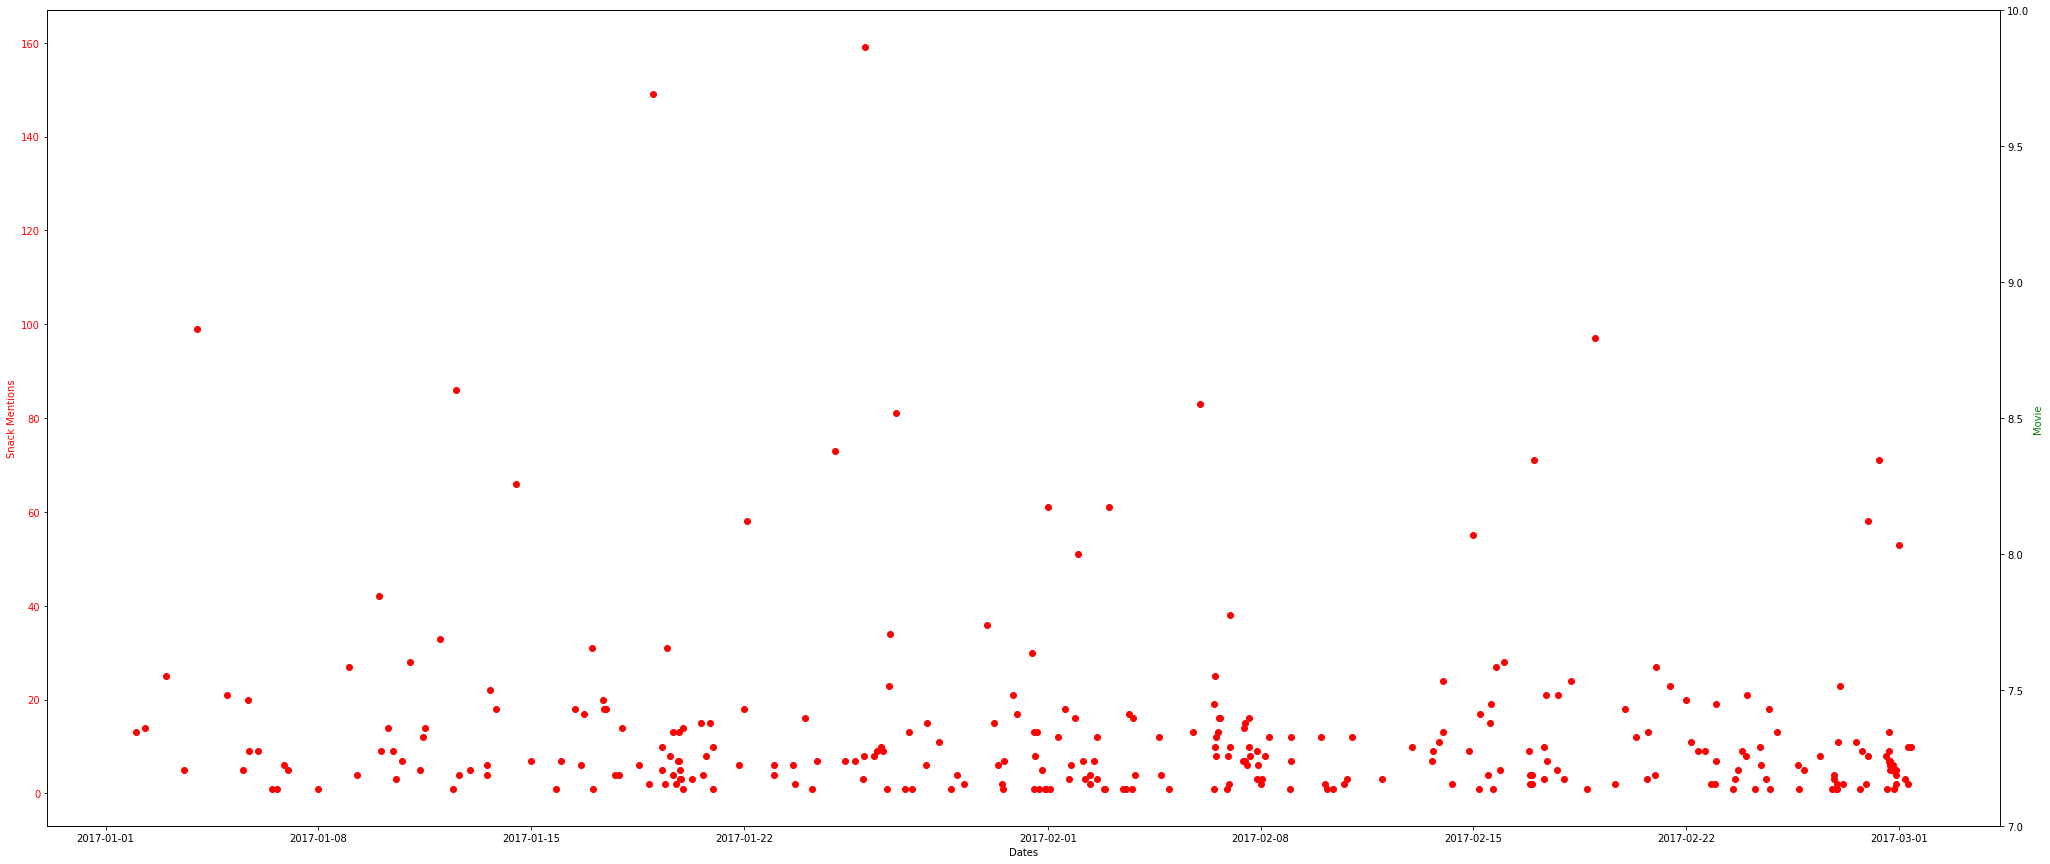

In [ ]:
movies= mv_df.groupby('vote_average').size().to_dict()
snacks = df.groupby('doc_date').size().to_dict()
x = list(snacks.keys())
y = list(snacks.values())
z = list(movies.values())

fig3, ax1 = plt.subplots(figsize=(35,15))
ax1.set_xlabel('Dates')
ax1.set_ylabel('Snack Mentions', color = 'red')
plot_1 = ax1.scatter(x[:300], y[:300], color = 'red')
ax1.tick_params(axis ='y', labelcolor = 'red')
# Adding Twin Axes
ax2 = ax1.twinx()
ax2.set_ylabel('Movie', color = 'green')
ax2.set_ylim([7, 10])
plot_2 = ax2.scatter(x[:300], z[:300], color = 'green')
ax2.tick_params(axis ='y', labelcolor = 'green')


Prediction?